In [1]:
# General use
import pandas as pd
import numpy as np
import os
import time

# Plotting
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


In [2]:
# For time series analysis
from statsmodels.tsa.stattools import adfuller, kpss  # for ADF and KPSS Tests
from scipy import stats, special  # for BoxCox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # for ACF and PACF
from tbats import TBATS
import joblib  # model saving
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # metrics

In [ ]:
# !pip install tbats

# Data Processing

In [3]:
# from google.colab import drive

# drive.mount('/content/drive') 
# path = os.path.expanduser(f'/content/drive/My Drive/Colab Notebooks/city_traffic_forecasting/')
# df = pd.read_csv(os.path.join(path, 'traffic_data/train_ML_IOT.csv'))
# df_blind = pd.read_csv(os.path.join(path, 'traffic_data/test_ML_IOT.csv'))

Mounted at /content/drive


In [4]:
# Read in the data
df = pd.read_csv(os.path.join(os.getcwd(), "traffic_data", "train_ML_IOT.csv"))
df_blind = pd.read_csv(os.path.join(os.getcwd(), "traffic_data", "test_ML_IOT.csv"))


In [5]:
def processing(df, is_blind=False):
    # if it's a blind set, there's no Vehicles column
    if is_blind:
      # Take out ID column
      df = df.loc[:, ['DateTime', 'Junction']]
    else:
      # Take out ID column
      df = df.loc[:, ['DateTime', 'Junction', 'Vehicles']]

    # Convert date from string to datetime
    df['DateTime'] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")

    # Create year, month, date columns
    df['year'] = df['DateTime'].dt.year
    df['month'] = df['DateTime'].dt.month
    df['date'] = df['DateTime'].dt.day
    # Create weekday. Monday is 0, Sunday is 6
    df['weekday'] = df['DateTime'].dt.weekday
    df.loc[df['weekday']==0,'weekday'] = "Monday"
    df.loc[df['weekday']==1,'weekday'] = "Tuesday"
    df.loc[df['weekday']==2,'weekday'] = "Wednesday"
    df.loc[df['weekday']==3,'weekday'] = "Thursday"
    df.loc[df['weekday']==4,'weekday'] = "Friday"
    df.loc[df['weekday']==5,'weekday'] = "Saturday"
    df.loc[df['weekday']==6,'weekday'] = "Sunday"
    # Create hour column
    df['hour'] = df['DateTime'].dt.hour

    # Divide into different traffic junctions
    df1 = df.loc[df["Junction"]==1, :]
    df2 = df.loc[df["Junction"]==2, :]
    df3 = df.loc[df["Junction"]==3, :]
    df4 = df.loc[df["Junction"]==4, :]

    print("Junction 1:", df1.shape, "; Junction 2:", df2.shape, "; Junction 3:", df3.shape, "; Junction 4:", df4.shape)
    
    return df1, df2, df3, df4


In [6]:
# Process both train-test and blind data
df1, df2, df3, df4 = processing(df)
df1_blind, df2_blind, df3_blind, df4_blind = processing(df_blind, is_blind=True)


Junction 1: (14592, 8) ; Junction 2: (14592, 8) ; Junction 3: (14592, 8) ; Junction 4: (4344, 8)
Junction 1: (2952, 7) ; Junction 2: (2952, 7) ; Junction 3: (2952, 7) ; Junction 4: (2952, 7)


# Plotting Function

In [7]:
def plot_predictions(prediction, date_range, title, save_path, actual=None, ci_lower=None, ci_upper=None):
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1) 

    # If there is actual data
    if actual is not None:
        # Calculate some metrics
        print("MSE of Model prediction:", mean_squared_error(actual, prediction))
        print("MAE of Model prediction:", mean_absolute_error(actual, prediction))
        print("Rsquared of Model prediction:", r2_score(actual, prediction))

        # Plot actual
        ax.plot(date_range,list(actual), label='actual')

    # If there is confidence interval
    if (ci_lower is not None) and (ci_upper is not None):
        # Plot Confidence Interval
        ax.fill_between(date_range, ci_lower, ci_upper, color='orange', alpha=0.2)  # alpha is level of transparency of the color

    # Plot predictions
    ax.plot(date_range,list(prediction), label="prediction")
    
    # Get ticks every 7 days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    # Prevent plotting scientific notation on axis
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    plt.ylabel('# of Vehicles', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.show()
    
    # Save fig
    fig.savefig(os.path.join(save_path, title+'.png'), bbox_inches='tight')
    


In [8]:
def plot_vehicles(vehicles, date_range, title):
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1) 

    # Plot predictions
    plt.plot(date_range,list(vehicles))
    
    # Get ticks every 1 month
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    # Prevent plotting scientific notation on axis
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    plt.ylabel('# of Vehicles', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.title(title, fontsize=18, fontweight='bold')
    plt.show()
    

# Extract Data for Hypothesis Testing and Transformations

Most time series models require the data to be stationary. Stationarity means that the data points are not dependent on time, meaning they have a constant mean, constant variance, and general randome patterns throughout time. The data points, however, can be dependent on previous data points. Thus, the 3 components we want to focus on to determine stationarity are:

1) Trend (changes in trend indicates non-constant mean)
<br>2) Variance (changes in variance indicates non-constant variance)
<br>3) Seasonality (repeated pattern in data that indicates it's dependent on time)

In [9]:
# Take vehicles data
series = df1['Vehicles'].values
dates = df1['DateTime'].values

# KPSS Test
KPSS is a unit root test. The presence of a unit root means there's a stochastic trend. So failing to reject Ho means the series is trend stationary (either has a deterministic trend or no trend). 

Ho: The process has no unit root (there's a deterministic trend or no trend, trend stationary)

Ha: The series has a unit root (there's a stochastic trend).

Let's set our alpha = 0.05

Note: This tests for the presence of a stochastic trend. Deterministic trend, lack of a trend, seasonality, and variance can't be determined here. We actually have to input seasonal periods into the test to ensure accurate analysis. We used lag 24*7 because we expect that there's a strong relationship between each week ("season" repeats after each week). To determine if there's a deterministic trend or not, we have to go to the next step, the ADF Test. 

In [10]:
# Define function for kpss test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags=24*7)  # lag 24*7 for each week
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

In [12]:
#apply kpss test on the series
kpss_test(series)

Results of KPSS Test:
Test Statistic             8.504222
p-value                    0.010000
Lags Used                168.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The p-value of 0.01 < 0.05, so we reject Ho, and conclude that the series is <b>not trend stationary</b>, meaning that there's stochastic trend. We will need to perform differencing to get rid of the stochastic trend. 

# Augmented Dickey Fuller Test

Similarly, ADF tests if a process has a unit root. The presence of a unit root indicates that there is a trend, so the process is time-dependent, and not stationary.

Ho: The series has a unit root (there's a stochastic or deterministic trend, series is not stationary)

Ha: The series has no unit root (there's no trend)

Let's set our alpha = 0.05

Note: This tests for presence of a trend. Seasonality and variance can't be determined here. We actually have to input seasonal periods into the test to ensure accurate analysis. We used lag 24*7 because we expect that there's a strong relationship between each week ("season" repeats after each week)

In [11]:
# Define function for ADF test
def adf_test(timeseries):
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=24*7)  # lag 24*7 for each week
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [13]:
#apply adf test on the series
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                    -0.257913
p-value                            0.931257
# of Lags Used                   168.000000
Number of Observations Used    14423.000000
Critical Value (1%)               -3.430803
Critical Value (5%)               -2.861740
Critical Value (10%)              -2.566877
dtype: float64


The p-value of 0.93 > 0.05, thus, we fail to reject Ho. The series has a unit root and is <b>not stationary</b>, and we already know from the KPSS test that the series has a stochastic trend.

# Differencing and Transforming

### Original Data
Just from visual observation, the data has 1) increasing trend, 2) increase variance (data is "fanning" out as time increases). Based on the exploratory analysis in the visualization notebook, there is also 3) daily, weekly, and annual seasonalities

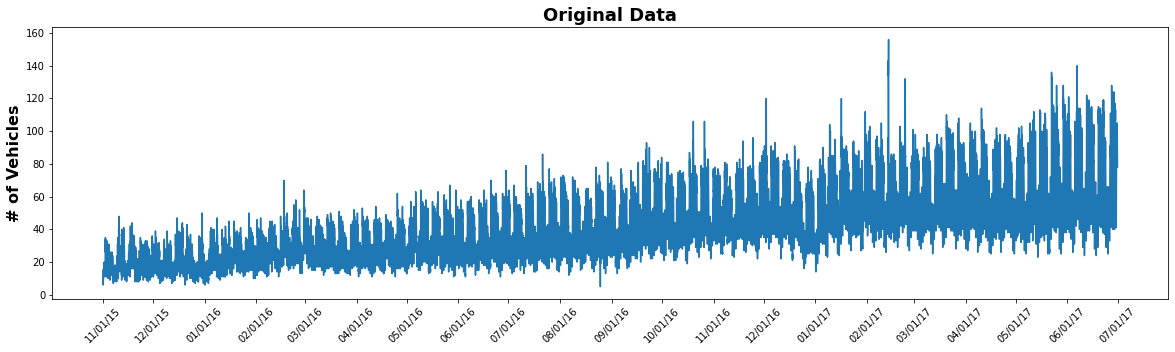

In [14]:
plot_vehicles(series, dates, 'Original Data')

### Differencing
Differencing the data by 1 day (vehicles on day_n - vehicles on day_n-1) will get rid of the stochastic trend in the data.

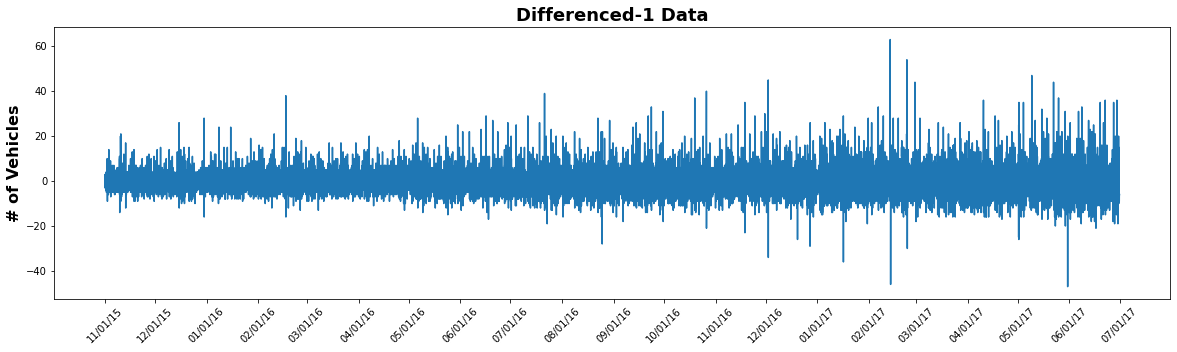

In [16]:
series_diff1 = pd.Series(series).diff(1)

plot_vehicles(series_diff1, dates, 'Differenced-1 Data')


In [16]:
kpss_test(series_diff1.dropna())
adf_test(series_diff1.dropna())


Results of KPSS Test:
Test Statistic             0.03725
p-value                    0.10000
Lags Used                168.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64
Results of Dickey-Fuller Test:


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Test Statistic                   -29.000492
p-value                            0.000000
# of Lags Used                   168.000000
Number of Observations Used    14422.000000
Critical Value (1%)               -3.430804
Critical Value (5%)               -2.861740
Critical Value (10%)              -2.566877
dtype: float64


At the p-value = 0.05, we fail to reject Ho of the KPSS test, which means the series is trend stationary. There's either a deterministic trend or no trend. At the p-value = 0.05, we reject Ho of the ADF test, which means that now, the series has no trend. 

### Box Cox Transformation
Box Cox transformation is used to 'normalize' data. In this case, it's used to achieve constant variance over time.

Lambda that gives Maximum Log Likelihood: 0.23755533174941695
Confidence Interval of Lambda: (0.20105560038525355, 0.27416610317322176)


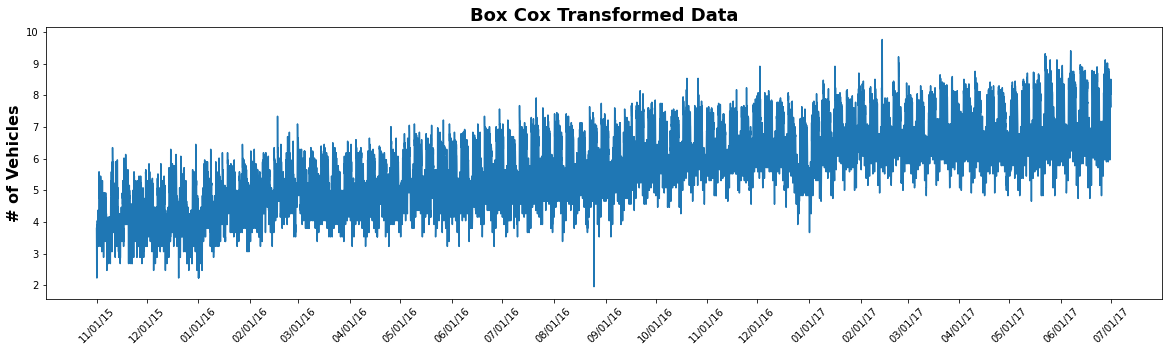

In [17]:
series_boxcox, maxlog_lambda, conf_int = stats.boxcox(series, alpha=0.01)
print("Lambda that gives Maximum Log Likelihood:", maxlog_lambda)
print("Confidence Interval of Lambda:", conf_int)

# To inverse transform Box Cox
# special.inv_boxcox(series_boxcox, maxlog_lambda)

plot_vehicles(series_boxcox, dates, 'Box Cox Transformed Data')

After transforming, the data is no longer "fanning" out, we've normalized it!

### Log Transformation
Taking the log of the data can also result in constant variance over time.

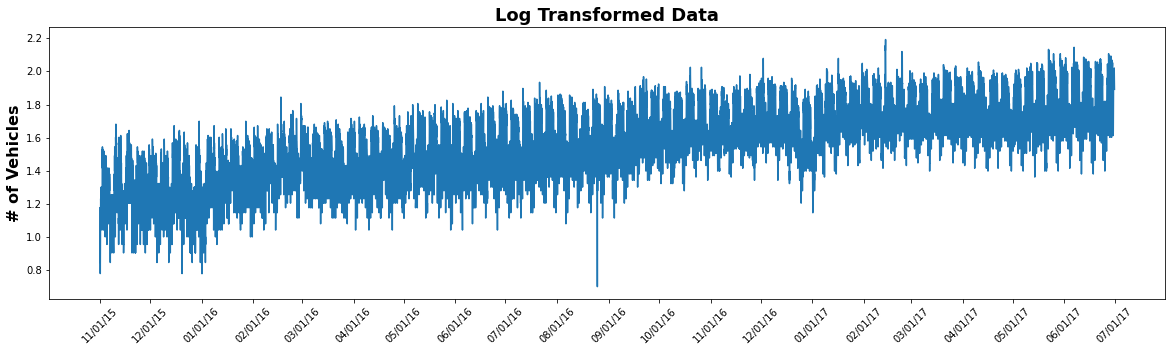

In [18]:
series_log = np.log10(series)

# Undo log transform
# series_10 = 10 ** series_log

plot_vehicles(series_log, dates, 'Log Transformed Data')

### Box Cox and Differencing
Combining both techniques to get rid of stochastic trend and increasing variance

Lambda that gives Maximum Log Likelihood: 0.23755533174941695
Confidence Interval of Lambda: (0.20105560038525355, 0.27416610317322176)


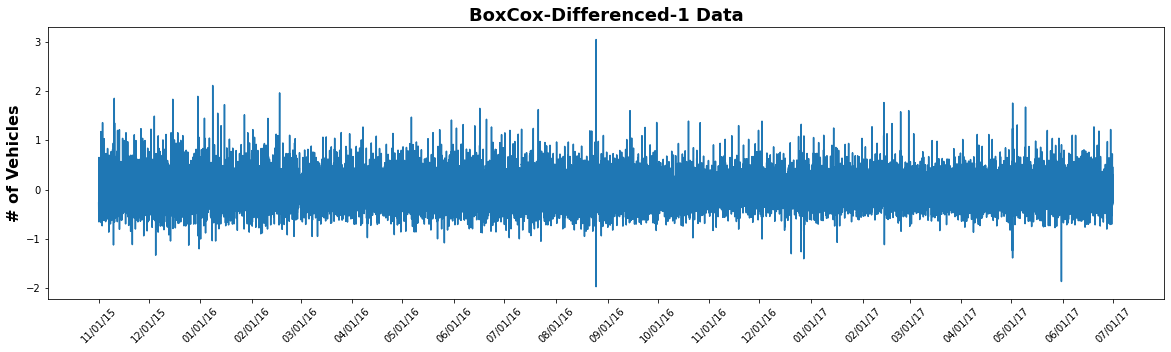

In [12]:
# Box Cox Transform
series_boxcox, maxlog_lambda, conf_int = stats.boxcox(series, alpha=0.01)
print("Lambda that gives Maximum Log Likelihood:", maxlog_lambda)
print("Confidence Interval of Lambda:", conf_int)

# Differencing by 1 day
series_bcd1 = pd.Series(series_boxcox).diff(1)

plot_vehicles(series_bcd1, dates, 'BoxCox-Differenced-1 Data')



### Seasonality and ACF/PACF Plots

ACF and PACF plots display how the data are correlated, which will inform us on the order of our ARMA model. The ACF plot will inform us on the MA order (q), while the PACF plot will inform us on the AR order (p). Through these plots, we can also look at seasonality in our data.

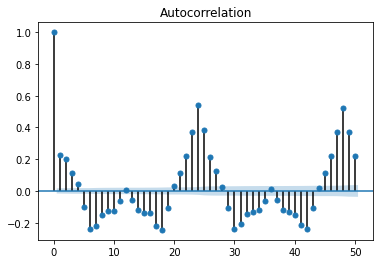

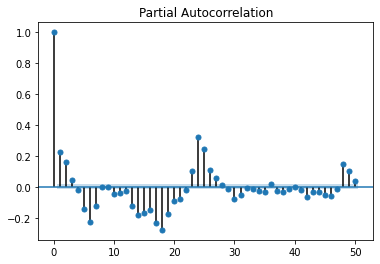

In [25]:
# Use the transformed data by differencing the BoxCox
plot_acf(series_bcd1.dropna(), lags=50)  #lags indicate show how many lags on the plot
plt.show()

plot_pacf(series_bcd1.dropna(), lags=50)
plt.show()

Both plots display a sinusoidal pattern that indicates <b>strong seasonality</b> in the data. From the ACF plot, the cut off seems to be at the 4th lag, so we expect the <b>MA order</b> to be around 4. From the PACF plot, the cut off seems to be at the 3rd lag, so we expect the <b>AR order</b> to be around 3.

# TBATS

### Split into train and test sets

Use 20% of the data for testing.

In [13]:
# Set training size and testing size

# Test size is 20% of all data
TEST_SIZE = round(len(series) * .2)
# Split point b/w train and test is the point where the test set begins + past history size
TRAIN_SPLIT = len(series) - TEST_SIZE

train = series[:TRAIN_SPLIT]
test = series[TRAIN_SPLIT:]

### Model
TBATS is a time series model that 
<br>1) Finds the best transformation for our series.
<br>2) Searches for the best hyperparameters.
<br>3) Trains our data and provides the resulting model.
<br>Thus, we don't need to make any changes to our series before feeding it to TBATS. 

However, because TBATS can take quite a long time to run, to avoid long run times and computational inefficiencies, we followed the guidelines below to train TBATS:
<br>1) Set the seasonal periods. In our case, we expect there to be cycles in traffic every day (as traffic tends to peak in the morning and dies down in the night), week (every Monday traffic should be similar), and year (certain months will repeatedly get more traffic than others). 
<br>2) Set use_box_cox and use_arma_errors to be False. Run TBATS and get the use_trend and use_damped_trend results (in our case, both are False).
<br>3) Run TBATS again with use_trend and use_damped_trend results, and get the use_box_cox and use_arma_errors results (True and True, arima p=2 q=3).
<br>4) Run all the parameters together to get the final TBATS model.

In [ ]:
start_time = time.time()

# Fit the model
tbats_obj = TBATS(seasonal_periods=[24, 24*7, 24*7*365], use_trend=False, use_damped_trend=False, use_arma_errors=True, use_box_cox=True) 
tbats_model = tbats_obj.fit(train)

print("--- %s seconds ---" % (time.time() - start_time))


In [14]:
# save the model
joblib.dump(tbats_model, os.path.join(path, 'traditional_time_series_results', 'TBATS_model.sav'))

# load model
# tbats_model = joblib.load(os.path.join(path, 'traditional_time_series_results', 'TBATS_model.sav'))

In [15]:
print(tbats_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [2.400e+01 1.680e+02 6.132e+04]
Seasonal harmonics [11  6  1]
ARMA errors (p, q): (2, 3)
Box-Cox Lambda 0.100420
Smoothing (Alpha): 0.528369
Seasonal Parameters (Gamma): [ 3.48188630e-06 -1.44163602e-07  1.43121384e-05 -1.28397572e-05
  1.45752100e-06 -6.60843844e-06]
AR coefficients [-1.28397572e-05  1.45752100e-06]
MA coefficients [-6.60843844e-06 -7.89595464e-02 -8.82780572e-02]
Seed vector [ 3.55332639e+00 -1.31123716e-01  2.08570503e-01 -1.93825904e-02
  9.75340264e-03  1.53857729e-02 -9.06238061e-03  3.65848509e-03
  3.96466721e-03 -7.28856202e-03  1.37020065e-02 -7.09950358e-03
 -4.81576480e-01 -1.43695234e-01  5.83824068e-02 -6.97710837e-03
  2.46483313e-02 -4.25546077e-02  7.17310932e-03  2.94416281e-03
  4.19713609e-03 -3.28438519e-03  7.64560856e-04 -3.04203981e-01
 -1.60164911e-01 -3.86010502e-02  4.42444271e-02  5.98816167e-02
  4.84532042e-02  1.08128487e-02 -3.91239953e-02 -4.01421858e-02
 -7.29

Examining the model summary, 

* TBATS seem to not have detected a trend in the data, so it could be that the stochastic trend we found was just a slight trend. 
* TBATS performed BoxCox transformation, as expected from the increasing variance in our data.
* The ARMA orders (p,q) are (2,3), and we expected (3,4), so we were close in our estimation.

Brief Residuals Analysis

Results of KPSS Test:
Test Statistic             1.020881
p-value                    0.010000
Lags Used                168.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Results of Dickey-Fuller Test:


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic                -8.018971e+00
p-value                        2.101304e-12
# of Lags Used                 1.680000e+02
Number of Observations Used    1.150500e+04
Critical Value (1%)           -3.430919e+00
Critical Value (5%)           -2.861791e+00
Critical Value (10%)          -2.566904e+00
dtype: float64


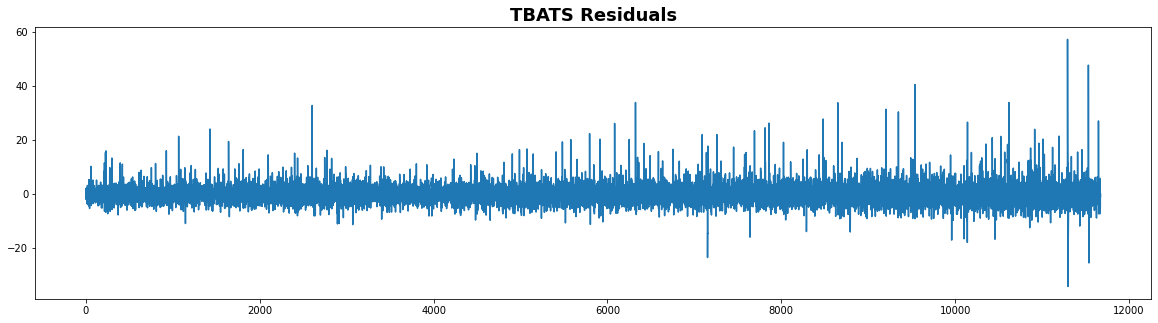

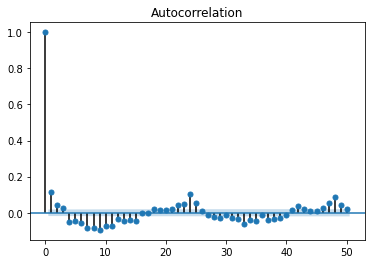

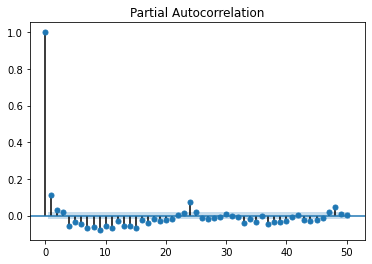

In [18]:
# Plot residuals
plt.figure(figsize=(20,5))
plt.title("TBATS Residuals", fontsize=18, fontweight='bold')
plt.plot(tbats_model.resid)

# Run unit root tests on residuals
kpss_test(tbats_model.resid)
# Reject Ho, series is not trend stationary

adf_test(tbats_model.resid)
# Reject Ho, series has no trend is stationary

plot_acf(tbats_model.resid, lags=50)  #lags indicate show how many lags on the plot
plt.show()

plot_pacf(tbats_model.resid, lags=50)
plt.show()



* Trend: From the residuals plot, we can see that the residuals seem to be centered around 0, indicating a constant mean. We reject Ho in the KPSS Test, so we don't have a stochastic trend. We reject Ho in the ADF Test, so we don't have any trend.
* Although the residuals plot shows a slight increase in variance, overall, it's not too extreme so the variance is somewhat constant.
* From the ACF/PACF plots, there also seems to be a slight seasonal pattern, but it's not too extreme either.

### Test Set

In [19]:
# Forecast the length of test set
tbats_pred = tbats_model.forecast(steps=len(test))
# Take out the dates that are in test set
test_dates = dates[TRAIN_SPLIT:]

MSE of Model prediction: 72.70988569530324
MAE of Model prediction: 5.935941271491127
Rsquared of Model prediction: 0.8696653528940697


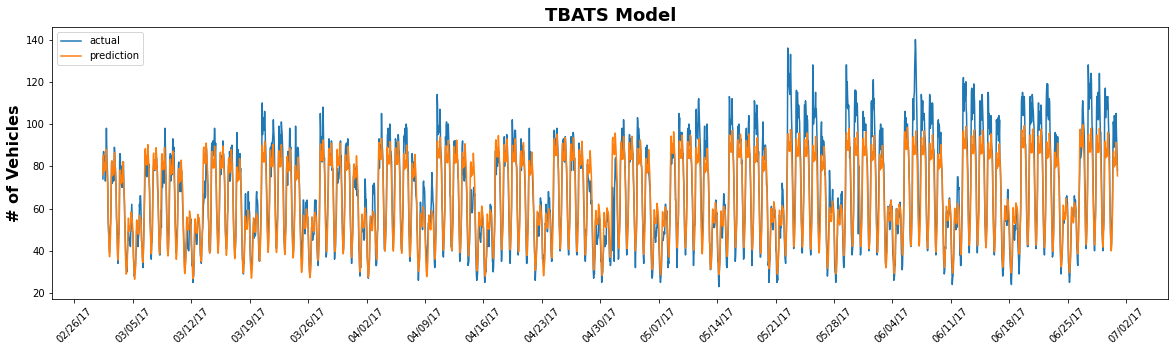

In [20]:
plot_predictions(actual=test, prediction=tbats_pred, date_range=test_dates, title='TBATS Model', 
                 save_path=os.path.join(path,'traditional_time_series_results'))


We can see that our model performs quite well in the test set, with the <b>rsquared</b> value of 0.87, meaning our model is able to explain <b>87% of the variation in our data</b>. The mean absolute error is ~6, meaning on average, the model is off in predicting by around <b>6 vehicles</b>.

In [ ]:
# Get the prediction intervals
tbats_pred_cilower = tbats_model.forecast(steps=len(test), confidence_level=0.50)[1]['lower_bound']
tbats_pred_ciupper = tbats_model.forecast(steps=len(test), confidence_level=0.50)[1]['upper_bound']

MSE of Model prediction: 72.70988569530324
MAE of Model prediction: 5.935941271491127
Rsquared of Model prediction: 0.8696653528940697


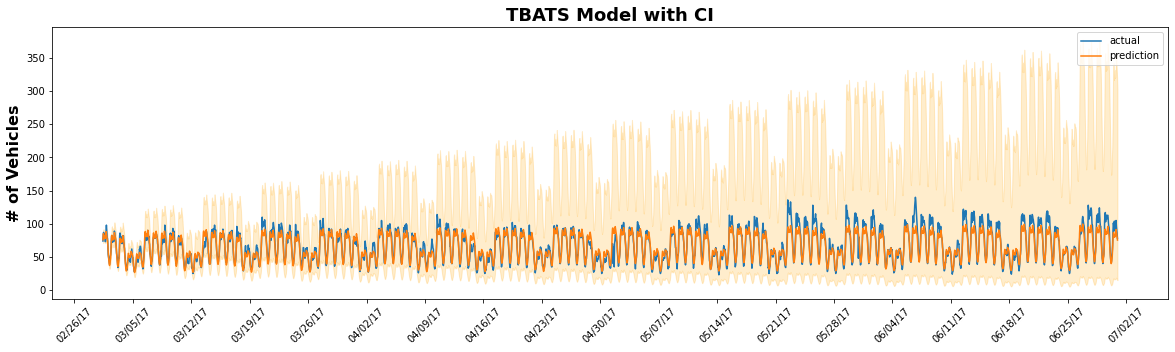

In [ ]:
plot_predictions(actual=test, prediction=tbats_pred, date_range=test_dates, title='TBATS Model with CI', 
                 save_path=os.path.join(path,'traditional_time_series_results'),
                 ci_lower=tbats_pred_cilower, ci_upper=tbats_pred_ciupper)

We set the confidence level of our prediction intervals to be 50%. Generally, we want to be 90% sure, but that will make our interval very wide, so for the sake of plotting, we just want to be 50% sure, which is quite narrow. 

Looking at the prediction intervals, we see that the farther out our predictions are, the wider the prediction interval, which makes sense as we are less sure about time that are farther into the future. However, even with a narrow confidence level, we see that all of our actual test data falls within the prediction intervals, indicating that our TBATS model generally does a good job of knowing where traffic volume are.